# Table of Contents
 <p>

In [1]:
using GaussianProcesses
using GaussianProcesses: cov
using Distributions
import PyPlot; plt=PyPlot
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [3]:
thresh = 0.0

# data-generating parameters
_σf_star = 1.0
_Lstar  = 1.05
_τstar = 0.7
_σy_star = 0.3

_στ2 = 100.0 # diffuse normal prior on τ
se = SEIso(log(_Lstar), log(√_σf_star))
n_xx = 1000
n_obs = 200
xx = collect(linspace(-10.0,10.0,n_xx))
_X = randn(n_obs)*2.0
# create a gap
_X[_X.>0.0] .+= 0.5
_X[_X.<0.0] .-= 0.5
gp_star = GP(;m=MeanZero(), k=se, logNoise=1e-8)

_f = rand(gp_star, vcat(xx, _X)')
_f_xx = _f[1:n_xx]
_f_obs = _f[n_xx+1:end]

noise = rand(Normal(0,_σy_star), n_obs)
_Y = _f_obs .+ noise .+ _τstar * (_X.>thresh)
;

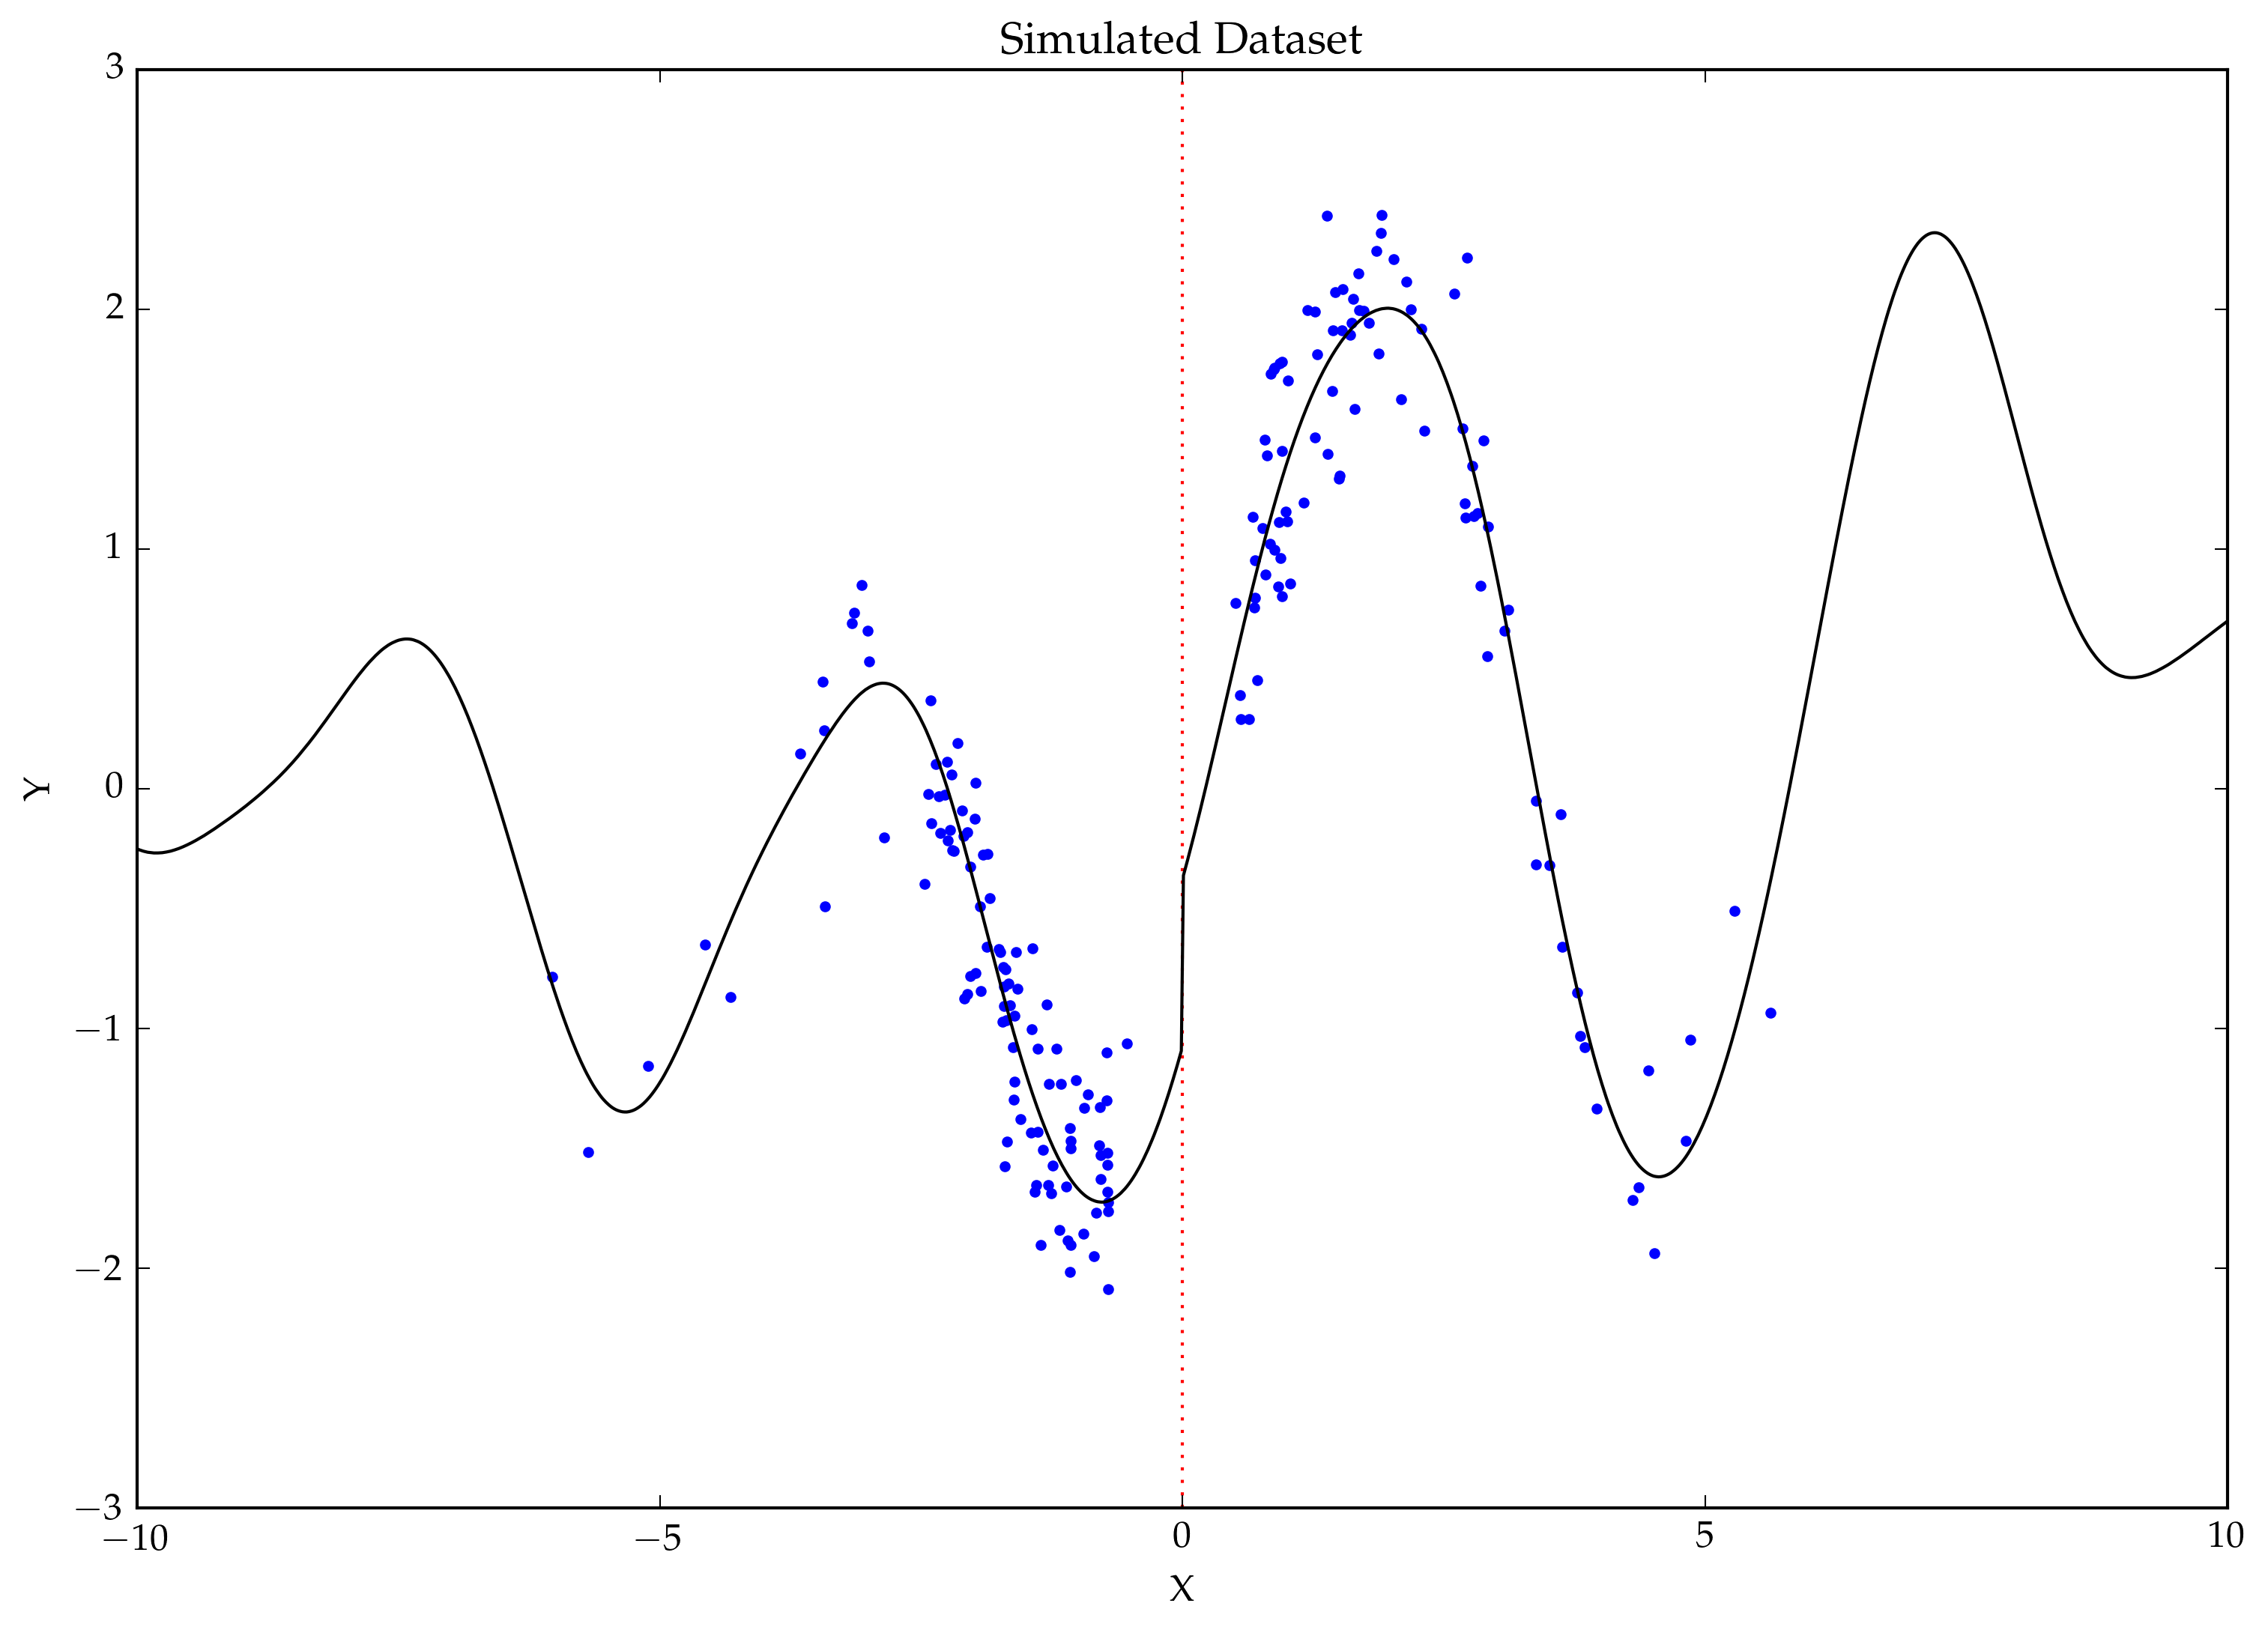

In [4]:
plt.svg(false)
plt.plot(_X, _Y, ".")
plt.axvline(x=0.0, color="red", linestyle=":")
plt.plot(xx, _f_xx+_τstar*(xx.>thresh), color="black", label="truth")
plt.title("Simulated Dataset")
plt.xlabel("X")
plt.ylabel("Y")
;

In [5]:
k_spatialslope = LinIso(0.0) * se + se

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.ProdKernel
    Type: GaussianProcesses.LinIso, Params: [0.0]
    Type: GaussianProcesses.SEIso, Params: [0.0487902,0.0]
  Type: GaussianProcesses.SEIso, Params: [0.0487902,0.0]


In [6]:
left = _X .< 0.0

lin_fit_left  = GP(_X[left]',  _Y[left],  MeanZero(), k_spatialslope, log(_σy_star))
lin_fit_right = GP(_X[!left]', _Y[!left], MeanZero(), k_spatialslope, log(_σy_star))

se_fit_left  = GP(_X[left]',  _Y[left],  MeanZero(), se, log(_σy_star))
se_fit_right = GP(_X[!left]', _Y[!left], MeanZero(), se, log(_σy_star))
;

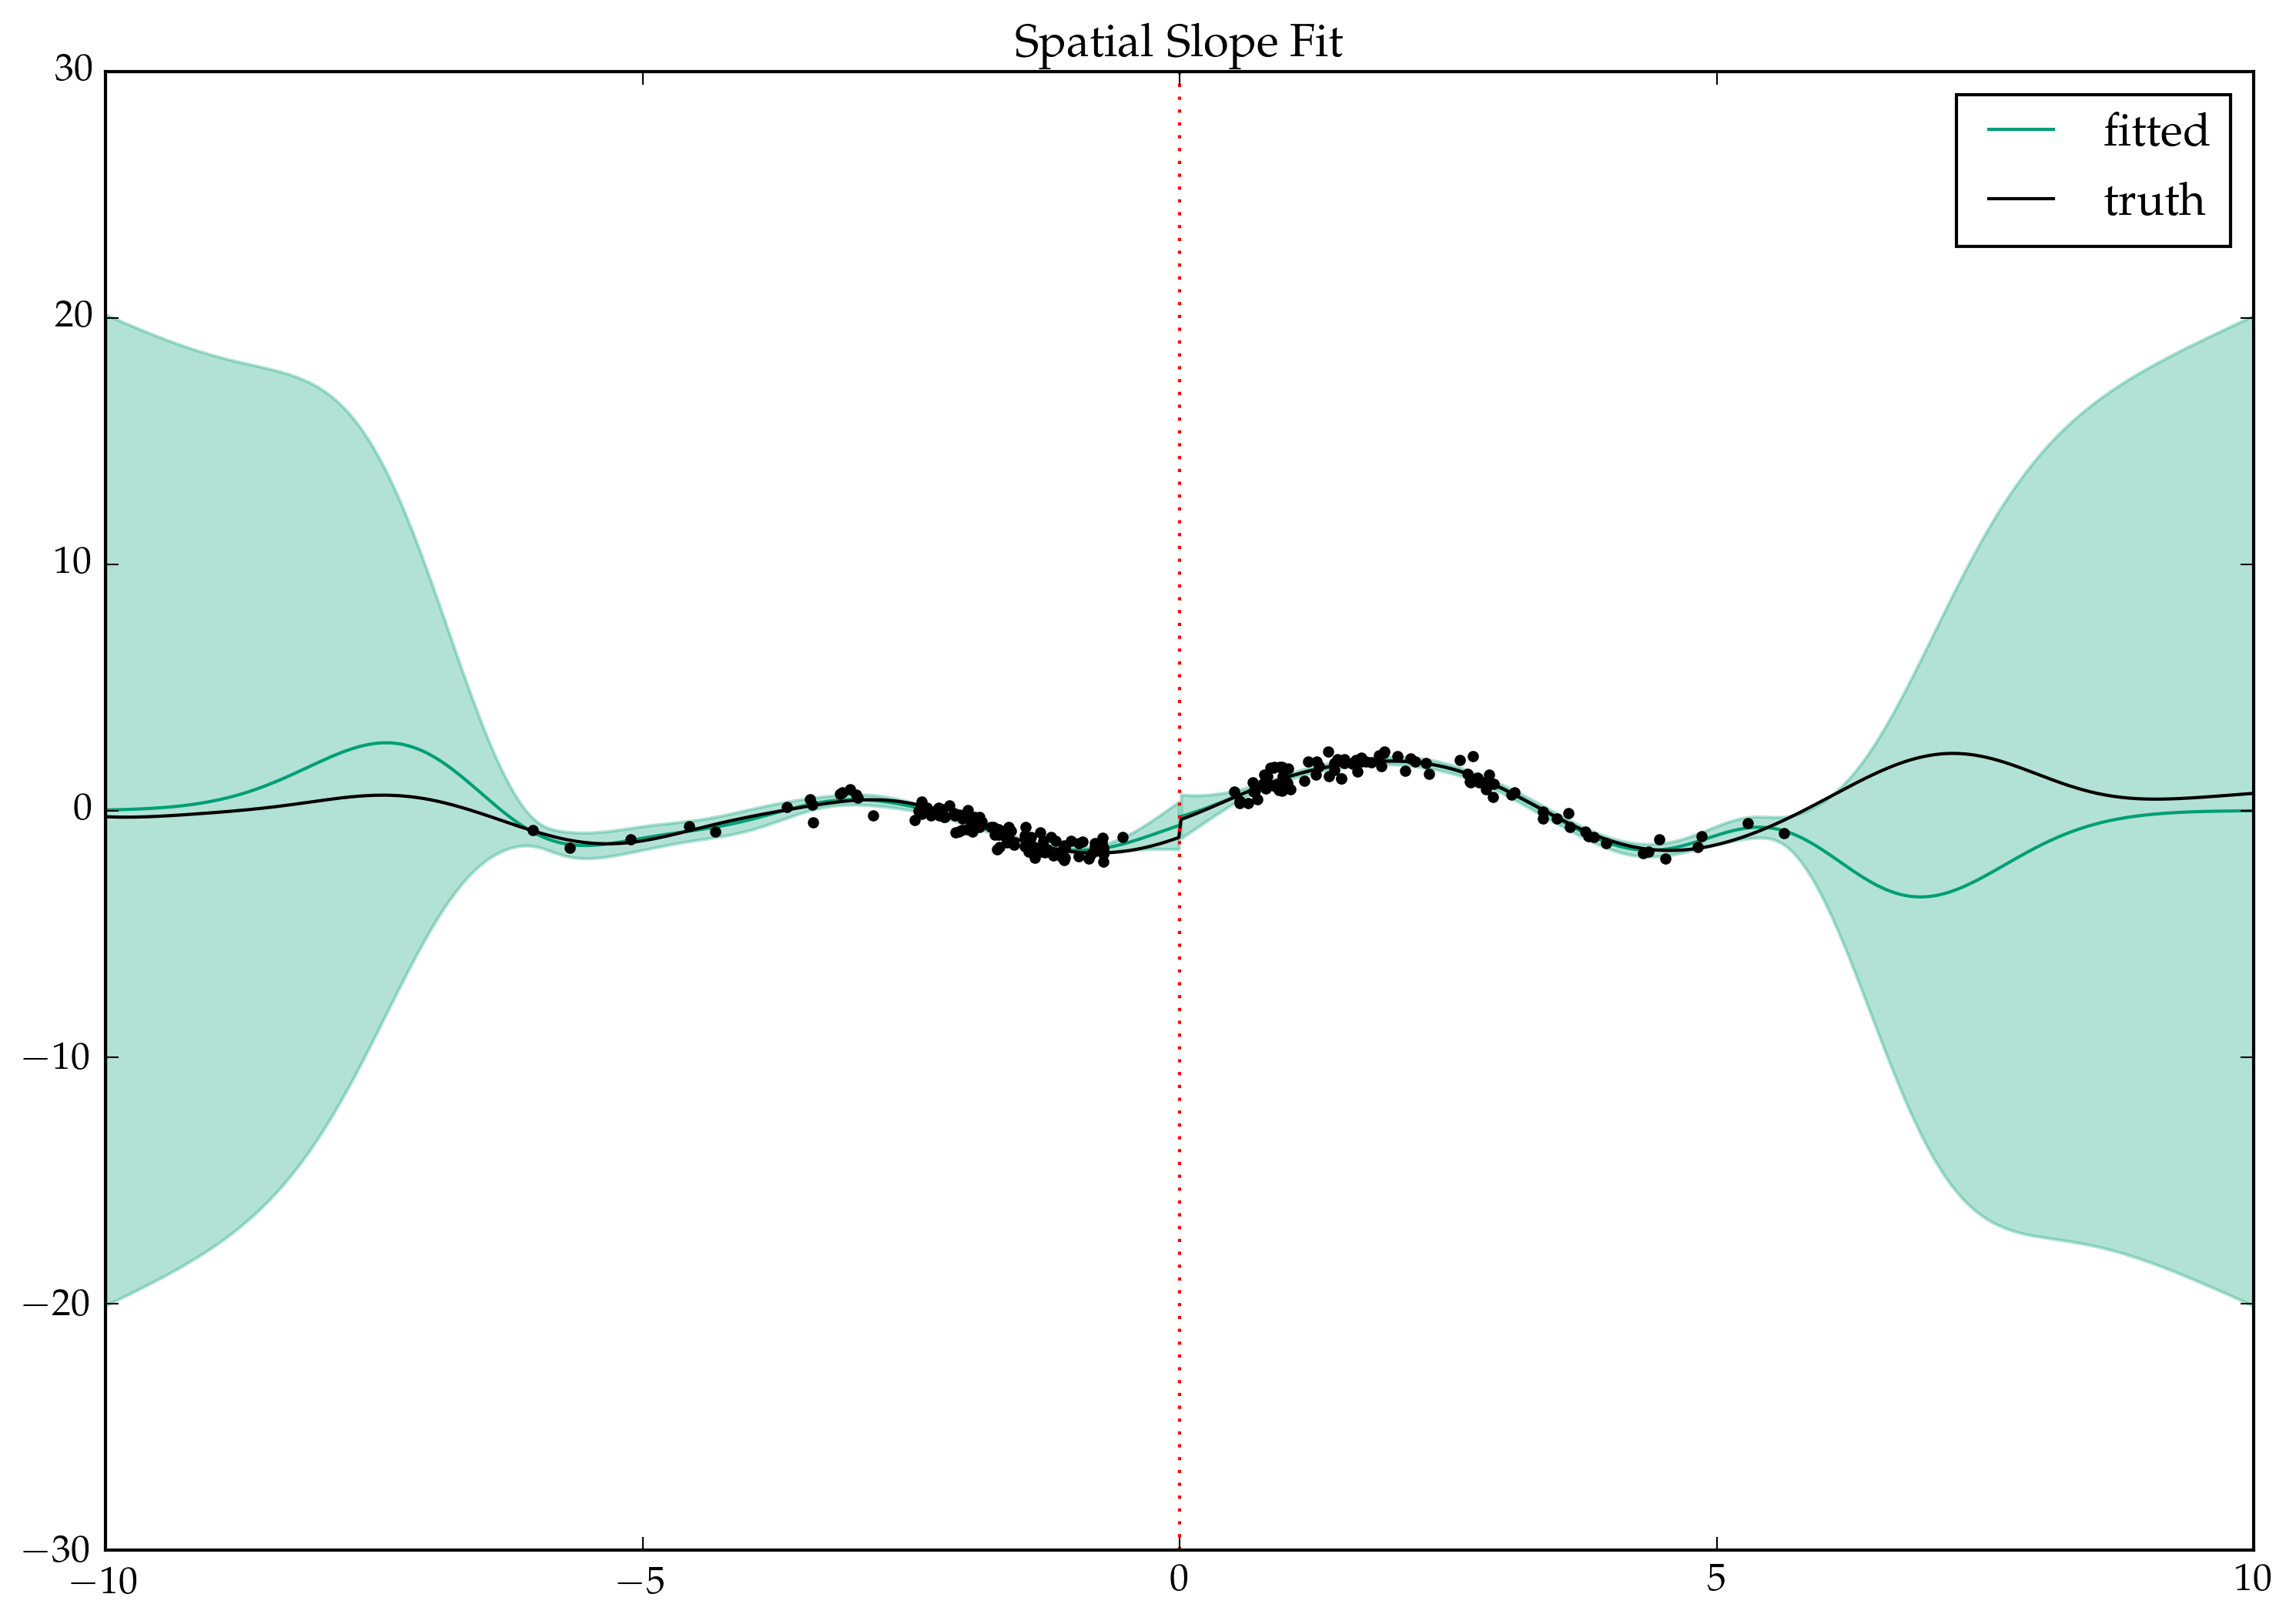

In [17]:
begin
    xx_left = xx .< 0.0
    xx_right = xx .> 0.0
    fit_right = lin_fit_right
    fit_left = lin_fit_left
    
    μ_left, Σ_left = predict(fit_left, xx[xx_left]')
    fit_color = "#009F77"
    plt.plot( xx[xx_left], μ_left, color=fit_color, label="fitted")
    lower = μ_left-2.0*√Σ_left
    upper = μ_left+2.0*√Σ_left
    plt.fill_between(xx[xx_left], lower, upper, color=fit_color, alpha=0.3)

    μ_right, Σ_right = predict(fit_right, xx[xx_right]')
    fit_color = "#009F77"
    plt.plot( xx[xx_right], μ_right, color=fit_color)
    lower = μ_right-2.0*√Σ_right
    upper = μ_right+2.0*√Σ_right
    plt.fill_between(xx[xx_right], lower, upper, color=fit_color, alpha=0.3)
    
    plt.plot(xx, _f_xx+_τstar*(xx.>thresh), color="black", label="truth")

    plt.plot(_X, _Y, ".", color="black")
    plt.axvline(x=0.0, color="red", linestyle=":")
    plt.legend(loc="bottom left")
end
plt.title("Spatial Slope Fit")
;

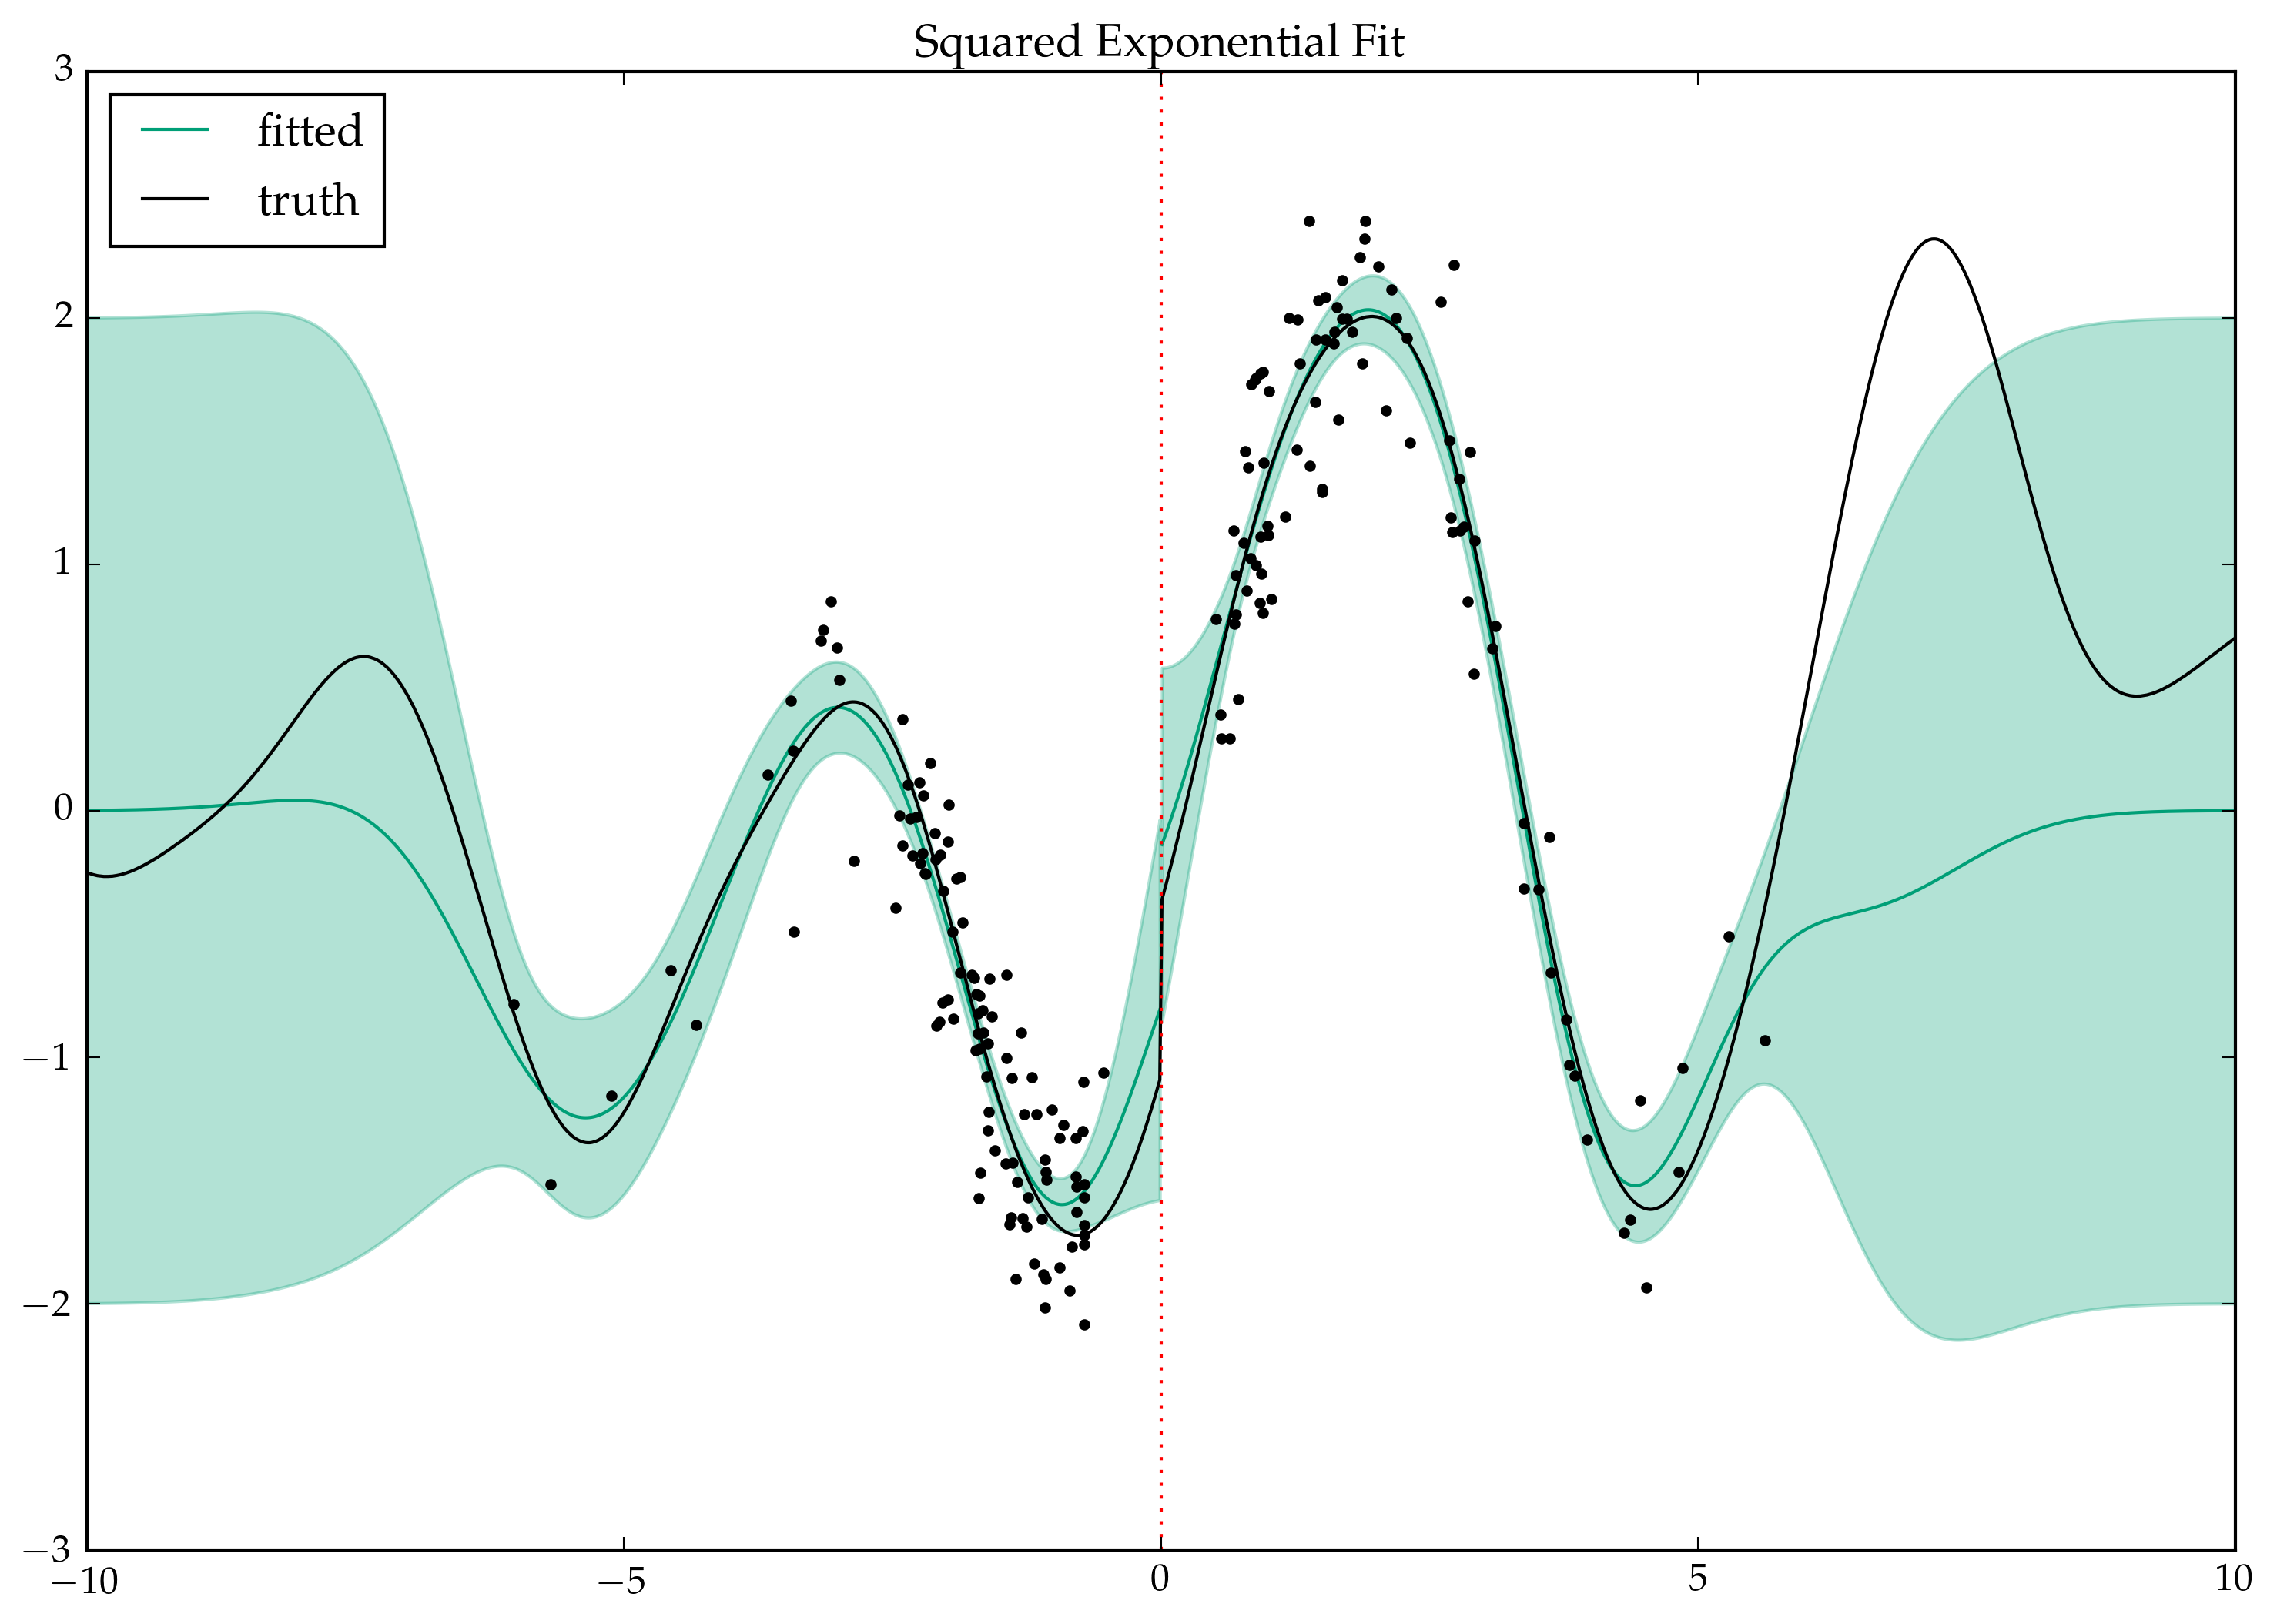

In [18]:
begin
    xx_left = xx .< 0.0
    xx_right = xx .> 0.0
    fit_right = se_fit_right
    fit_left = se_fit_left
    
    μ_left, Σ_left = predict(fit_left, xx[xx_left]')
    fit_color = "#009F77"
    plt.plot( xx[xx_left], μ_left, color=fit_color, label="fitted")
    lower = μ_left-2.0*√Σ_left
    upper = μ_left+2.0*√Σ_left
    plt.fill_between(xx[xx_left], lower, upper, color=fit_color, alpha=0.3)

    μ_right, Σ_right = predict(fit_right, xx[xx_right]')
    fit_color = "#009F77"
    plt.plot( xx[xx_right], μ_right, color=fit_color)
    lower = μ_right-2.0*√Σ_right
    upper = μ_right+2.0*√Σ_right
    plt.fill_between(xx[xx_right], lower, upper, color=fit_color, alpha=0.3)
    
    plt.plot(xx, _f_xx+_τstar*(xx.>thresh), color="black", label="truth")

    plt.plot(_X, _Y, ".", color="black")
    plt.axvline(x=0.0, color="red", linestyle=":")
    plt.legend(loc="bottom left")
end
plt.title("Squared Exponential Fit")
;

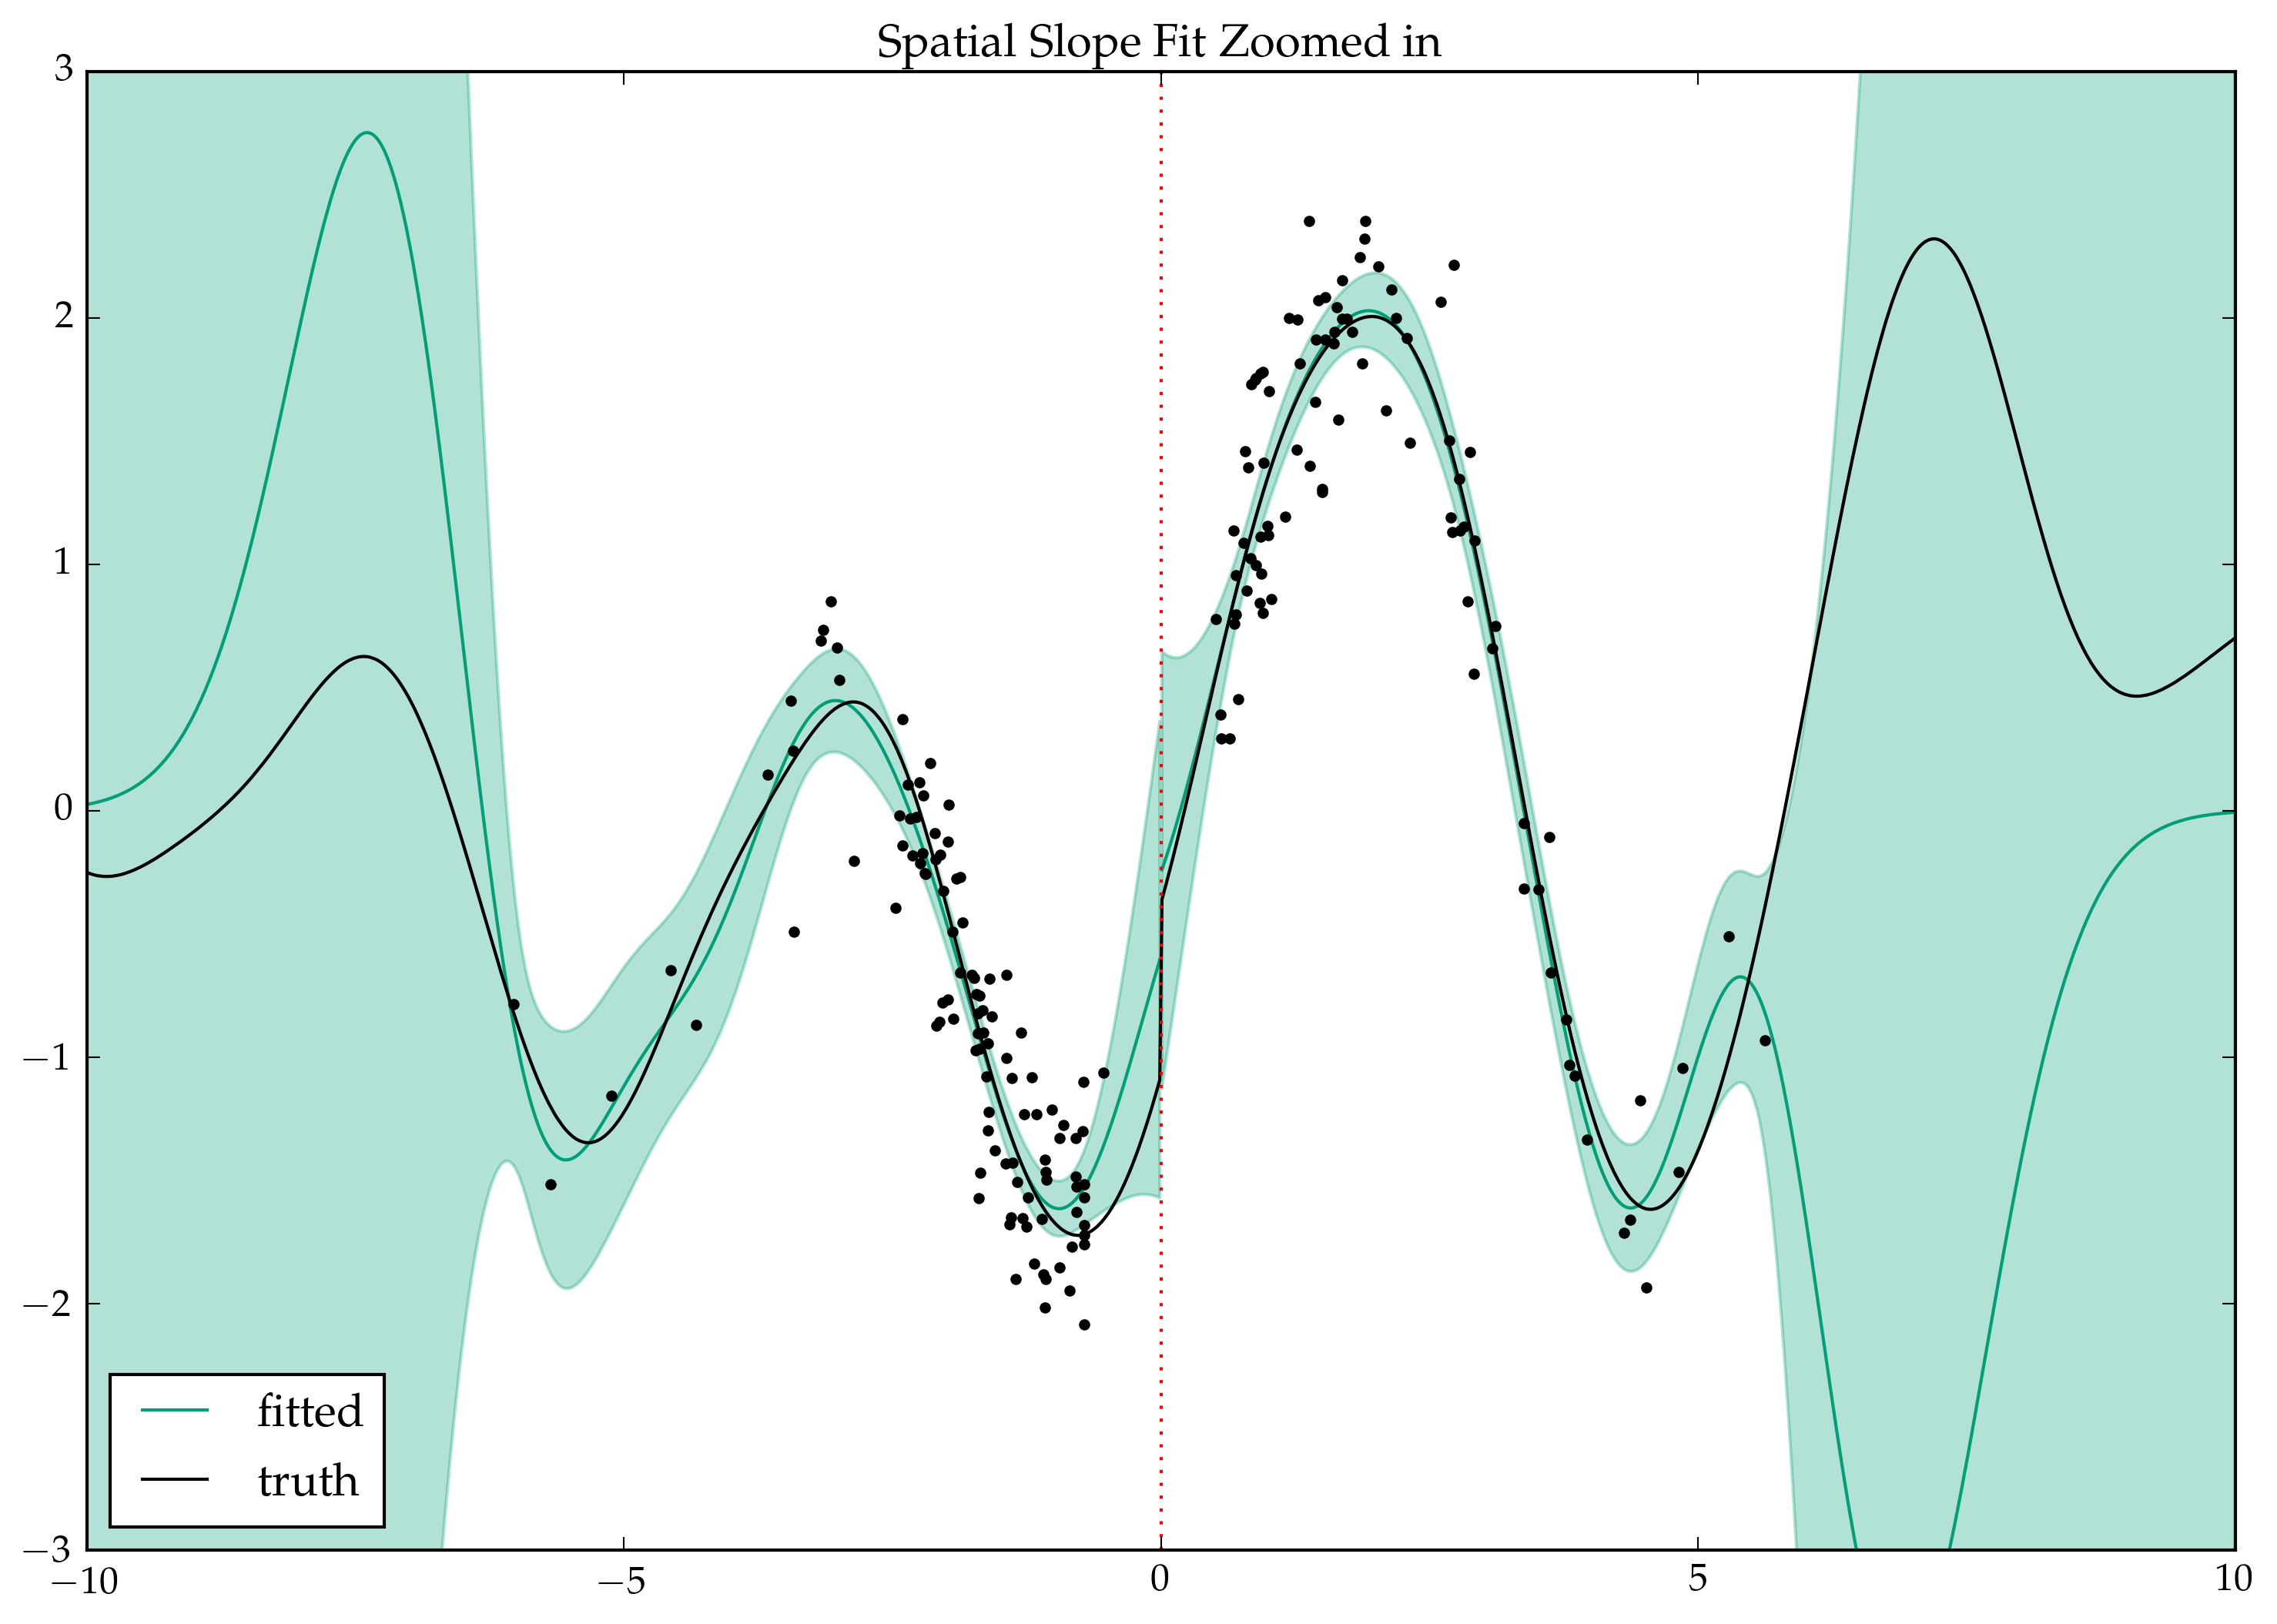

In [19]:
begin
    xx_left = xx .< 0.0
    xx_right = xx .> 0.0
    fit_right = lin_fit_right
    fit_left = lin_fit_left
    
    μ_left, Σ_left = predict(fit_left, xx[xx_left]')
    fit_color = "#009F77"
    plt.plot( xx[xx_left], μ_left, color=fit_color, label="fitted")
    lower = μ_left-2.0*√Σ_left
    upper = μ_left+2.0*√Σ_left
    plt.fill_between(xx[xx_left], lower, upper, color=fit_color, alpha=0.3)

    μ_right, Σ_right = predict(fit_right, xx[xx_right]')
    fit_color = "#009F77"
    plt.plot( xx[xx_right], μ_right, color=fit_color)
    lower = μ_right-2.0*√Σ_right
    upper = μ_right+2.0*√Σ_right
    plt.fill_between(xx[xx_right], lower, upper, color=fit_color, alpha=0.3)
    
    plt.plot(xx, _f_xx+_τstar*(xx.>thresh), color="black", label="truth")

    plt.plot(_X, _Y, ".", color="black")
    plt.axvline(x=0.0, color="red", linestyle=":")
    plt.legend(loc="bottom left")
end
plt.title("Spatial Slope Fit Zoomed in")
plt.ylim(-3.0,3.0)
;